# Understanding Generative Model via a simple AutoEncoder with a MNIST example

## By Wei Peng


# Vanilla AutoEncoders
We are trying to train a model in a self-supervised manner. By this way, we can get a compact representation of the input. There are two modules in an AutoEncoder model:
- Encoder: turn the input x (can be an image) into latent representation z;
- Decoder: reconstruct the input x from the latent representation z.


![autoencoder](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/ae_diagram.png?raw=1)

## Step 1: Donload the MNIST Dataset
The MNIST dataset contains handwritten digits in square images of 28x28 pixels of grayscale levels. There are 60,000 training images and 10,000 testing images from different writers.



In [39]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from sklearn import decomposition
from sklearn.datasets import fetch_openml

In [40]:
def downloadMNIST():
  """
  Download MNIST dataset and transform it to torch.Tensor

  Args:
    None

  Returns:
    x_train : training images (torch.Tensor) (60000, 28, 28)
    x_test  : test images (torch.Tensor) (10000, 28, 28)
    y_train : training labels (torch.Tensor) (60000, )
    y_train : test labels (torch.Tensor) (10000, )
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
  # Trunk the data
  n_train = 60000
  n_test = 10000

  train_idx = np.arange(0, n_train)
  test_idx = np.arange(n_train, n_train + n_test)

  x_train, y_train = X[train_idx], y[train_idx]
  x_test, y_test = X[test_idx], y[test_idx]

  # Transform np.ndarrays to torch.Tensor
  x_train = torch.from_numpy(np.reshape(x_train,
                                        (len(x_train),
                                         28, 28)).astype(np.float32))
  x_test = torch.from_numpy(np.reshape(x_test,
                                       (len(x_test),
                                        28, 28)).astype(np.float32))

  y_train = torch.from_numpy(y_train.astype(int))
  y_test = torch.from_numpy(y_test.astype(int))

  return (x_train, y_train, x_test, y_test)

In [41]:
# Download MNIST
x_train, y_train, x_test, y_test = downloadMNIST()

x_train = x_train / 255
x_test = x_test / 255

image_shape = x_train.shape[1:]

input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

print(f'shape x_train \t\t {x_train.shape}')
print(f'shape x_test \t\t {x_test.shape}')
print(f'shape image \t\t {image_shape}')
print(f'shape input_train \t {input_train.shape}')
print(f'shape input_test \t {input_test.shape}')


/usr/local/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


shape x_train 		 torch.Size([60000, 28, 28])
shape x_test 		 torch.Size([10000, 28, 28])
shape image 		 torch.Size([28, 28])
shape input_train 	 torch.Size([60000, 784])
shape input_test 	 torch.Size([10000, 784])


In [42]:
### Plot funtion for visualization:
def plot_row(images, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.

  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form

  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]

  for items_idx, items in enumerate(images):

    items = np.array(items)
    if items.ndim == 1:
      items = np.expand_dims(items, axis=0)

    if len(items) > show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    if image_shape is not None:
      items = items.reshape([-1] + list(image_shape))

    plt.figure(figsize=(len(items) * 1.5, 2))
    for image_idx, image in enumerate(items):

      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
      plt.axis('off')

      plt.tight_layout()

/var/folders/lz/vgx6vwgj5lx9lrh0326zx7xm0000gn/T/ipykernel_63937/3024717749.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


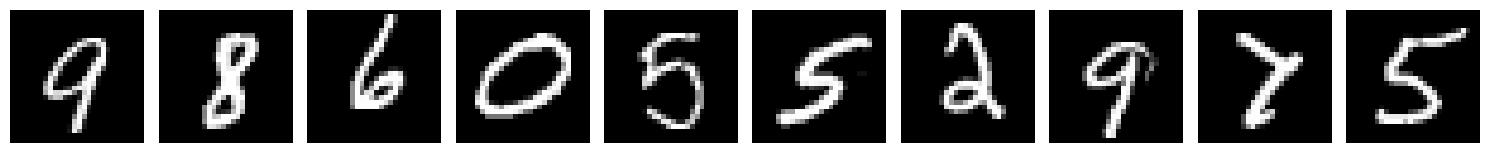

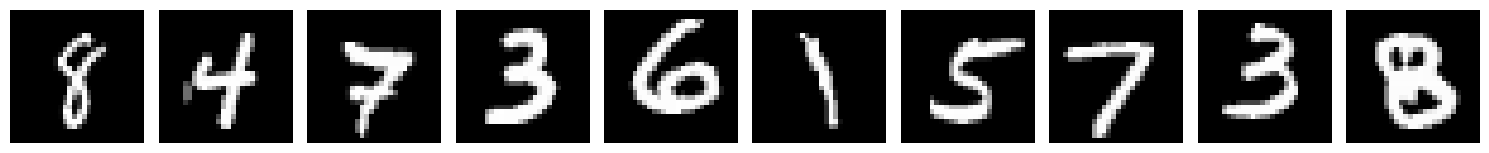

In [43]:
# top row: random images from test set
# bottom row: images selected with test_selected_idx

plot_row([x_train, x_test[test_selected_idx]])

## Step 2: Build the Encoder

![encoder](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/encoder_diagram.png?raw=1)

In [6]:
# Set random set

def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

In [47]:
## Build encoder model

class Encoder(nn.Module):
    def __init__(self, input_shape, out_basesize, z_size):
        super().__init__()
        self.input_shape = input_shape
        self.z_size = z_size
        self.base_model = nn.Sequential(
            #28 28 --> 784
            nn.Flatten(),
            # 784 -> 2048
            nn.Linear(input_shape, out_basesize), #np.prod(input_shape)
            nn.LeakyReLU(),
            # 2048 -> 2048
            nn.Linear(out_basesize, out_basesize),
            nn.LeakyReLU(),
        )
        self.lin_latent = nn.Linear(out_basesize, z_size)

    def forward(self, x):
        # forwards the input through the base model and then the "lin_latent" layer
        # to get the representation (z)
        base_out = self.base_model(x)
        out = self.lin_latent(base_out)
        return out


#### Call the Encoder model
set_seed(13)
# we defined our representation (z) as a vector of size one # our images are 1@28x28
z_size = 1
input_shape = 28 # (C, H, W)
out_basesize = 2048

encoder = Encoder(input_shape*input_shape, out_basesize, z_size)

In [48]:
encoder

Encoder(
  (base_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (lin_latent): Linear(in_features=2048, out_features=1, bias=True)
)

In [50]:
x = x_train[0:2]
z = encoder(x[:,None])
print(f'The input size is {x.shape}, the latent size is {z.shape}')

The input size is torch.Size([2, 28, 28]), the latent size is torch.Size([2, 1])


## Latent Space

![latent space](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/latent_space.png?raw=1)

## The Decoder

![decoder](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/decoder_diagram.png?raw=1)

In [51]:
decoder = nn.Sequential(
    # z_size -> 2048
    nn.Linear(z_size, 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
    # 2048 -> C*H*W
    nn.Linear(2048, input_shape*input_shape),
    # C*H*W -> (C, H, W)
    nn.Unflatten(1, (1, input_shape, input_shape))
)

In [52]:
decoder

Sequential(
  (0): Linear(in_features=1, out_features=2048, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=2048, out_features=2048, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=2048, out_features=784, bias=True)
  (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
)

In [53]:
x_tilde = decoder(z)
print(f'The recon x shape  is {x_tilde.shape}')

The recon x shape  is torch.Size([2, 1, 28, 28])


## AutoEncoder (AE)

In [54]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder

    def forward(self, x):
        # when encoder met decoder
        enc_out = self.enc(x)
        return self.dec(enc_out), enc_out

model_ae = AutoEncoder(encoder, decoder)

In [55]:
model_ae

AutoEncoder(
  (enc): Encoder(
    (base_model): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=2048, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=2048, out_features=2048, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
    )
    (lin_latent): Linear(in_features=2048, out_features=1, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=1, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=2048, out_features=784, bias=True)
    (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  )
)

### Model Training (AE)

In [18]:
set_seed(13)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_ae.to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model_ae.parameters(), 0.0003)

## This is the number of iteration
num_epochs = 5000

train_losses = []

for epoch in range(1, num_epochs+1):
    batch_losses = []
    batch_size = 100
    # Randomly sample a batch of sample
    train_selected_idx = np.random.choice(len(x_train), batch_size, replace=False)
    
    #for i, x in enumerate(x_train):
    model_ae.train()
    x = x_train[train_selected_idx]
    x = x[:,None].to(device)

    # Step 1 - Computes our model's predicted output - forward pass
    yhat,_ = model_ae(x)
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, x)
    # Step 3 - Computes gradients
    loss.backward()
    # Step 4 - Updates parameters using gradients and the learning rate
    optim.step()
    optim.zero_grad()

    batch_losses.append(np.array([loss.data.item()]))

    # Average over batches
    train_losses.append(np.array(batch_losses).mean(axis=0))

    if (epoch%100==0):
        print(f'Step {epoch:03d}/{num_epochs} | Loss >> {train_losses[-1][0]:.4f}')

Step 100/10000 | Loss >> 0.0532
Step 200/10000 | Loss >> 0.0530
Step 300/10000 | Loss >> 0.0495
Step 400/10000 | Loss >> 0.0497
Step 500/10000 | Loss >> 0.0516
Step 600/10000 | Loss >> 0.0504
Step 700/10000 | Loss >> 0.0484
Step 800/10000 | Loss >> 0.0526
Step 900/10000 | Loss >> 0.0506
Step 1000/10000 | Loss >> 0.0499
Step 1100/10000 | Loss >> 0.0470
Step 1200/10000 | Loss >> 0.0494
Step 1300/10000 | Loss >> 0.0497
Step 1400/10000 | Loss >> 0.0506
Step 1500/10000 | Loss >> 0.0479
Step 1600/10000 | Loss >> 0.0445
Step 1700/10000 | Loss >> 0.0493
Step 1800/10000 | Loss >> 0.0484
Step 1900/10000 | Loss >> 0.0495
Step 2000/10000 | Loss >> 0.0486
Step 2100/10000 | Loss >> 0.0476
Step 2200/10000 | Loss >> 0.0504
Step 2300/10000 | Loss >> 0.0445
Step 2400/10000 | Loss >> 0.0476
Step 2500/10000 | Loss >> 0.0460
Step 2600/10000 | Loss >> 0.0481
Step 2700/10000 | Loss >> 0.0461
Step 2800/10000 | Loss >> 0.0479
Step 2900/10000 | Loss >> 0.0470
Step 3000/10000 | Loss >> 0.0480
Step 3100/10000 | L

In [78]:
torch.save(model_ae.state_dict(), 'VAE_1d_latent.pth')


In [56]:
### You can also load model
model_ae.load_state_dict(torch.load('VAE_1d_latent.pth'))

<All keys matched successfully>

### Step3 Example of Reconstruction

In [57]:
# Randomly sample a batch of sample
batch_size = 10
test_selected_idx = np.random.choice(len(x_test), batch_size, replace=False)  
x_input  = x_test[test_selected_idx]

Here we show the original input (Top) and its reconstruction (Bottom):


/var/folders/lz/vgx6vwgj5lx9lrh0326zx7xm0000gn/T/ipykernel_63937/3024717749.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


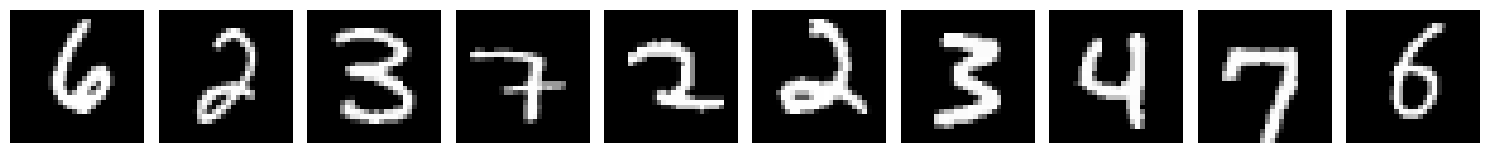

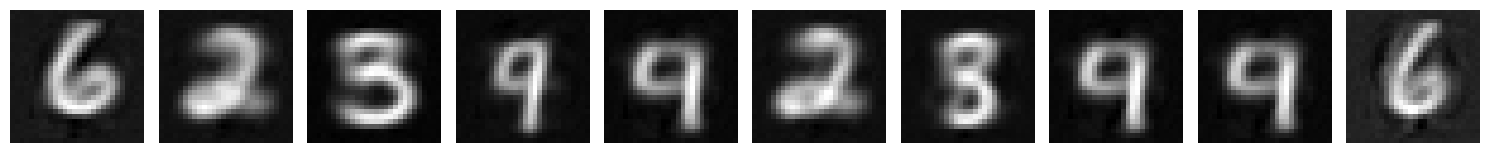

In [58]:
### Run the VAE to get the reconstruction of x
X_hat, latent_z = model_ae(x_input[:,None])
print(f'Here we show the original input (Top) and its reconstruction (Bottom):')        
plot_row([x_input.squeeze(1), X_hat.detach().numpy().squeeze(1)])

#### Things you can try to get better reconstruction result:
- You can try to make the latent space higher
- You can try to make both encoder and decoder deeper
- try different kinds of loss function

In [35]:
### What we learn from the latent space?
print(f'latent shape is {latent_z.shape} the value are: {latent_z}')

latent shape is torch.Size([10, 1]) the value are: tensor([[ 1.3605],
        [-0.2032],
        [-0.1652],
        [-0.5545],
        [ 0.0570],
        [-2.7100],
        [-0.0441],
        [ 0.5917],
        [ 1.3224],
        [-0.1259]], grad_fn=<AddmmBackward0>)


### Step 4 Model the Latent Distribution

In [59]:
### Run the whole dataset to get the latents, and save them in a list
latents_list = []
batch_size = 100
steps = len(x_train)//batch_size
for i in range(steps):
    if i%100==0:
        print(f'Extracting batch: {i}/{steps}')
    ### take the data from each step
    x_input = x_train[i*batch_size:i*batch_size+batch_size]
    ## fed them into encoder to get the latents
    _, z_latent = model_ae(x_input[:,None])
    latents_list.append(z_latent)
print('Done with the extracting!')
## concatenation of the list to a tensor
latents_list = torch.cat(latents_list)

Extracting batch: 0/600
Extracting batch: 100/600
Extracting batch: 200/600
Extracting batch: 300/600
Extracting batch: 400/600
Extracting batch: 500/600
Done with the extracting!


In [69]:
print(f'we have {len(latents_list)} latents in the list')
## compute the mean and variance of the latent 
print(f'the mean and viarance : {latents_list.min()} {latents_list.max()}, {latents_list.mean()}, {latents_list.std()}')
mean_std = torch.std_mean(latents_list)
print(f'Mean {mean_std[1]}, std: {mean_std[0]}')

we have 60000 latents in the list
the mean and viarance : -5.295138835906982 5.433820724487305, -0.07099571079015732, 1.0501832962036133
Mean -0.07099571079015732, std: 1.0501832962036133


### Step 5: Build your Generative Model

torch.Size([20, 1])


/var/folders/lz/vgx6vwgj5lx9lrh0326zx7xm0000gn/T/ipykernel_63937/3024717749.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


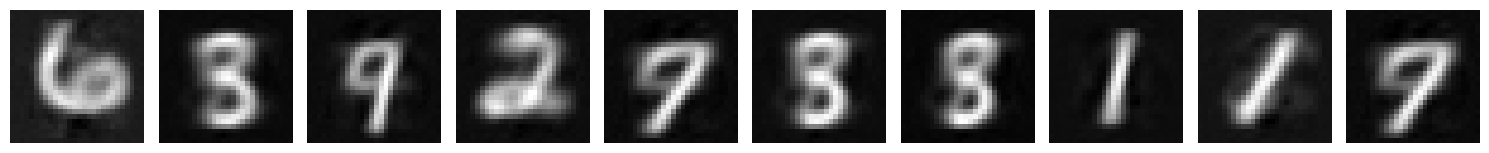

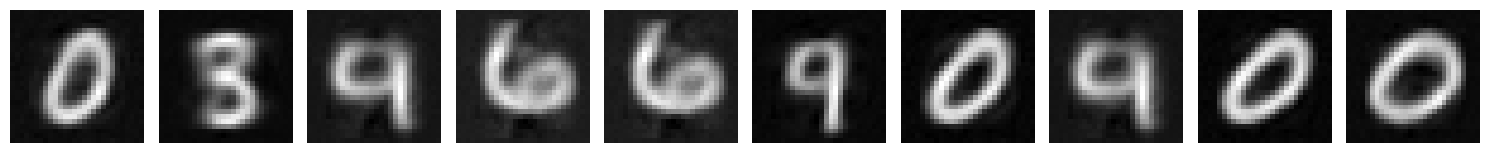

In [76]:
### build your latent distribution
batch_size = 20

sampled_z = torch.normal(-0.0709, 1.05018, size=(batch_size,1))
print(sampled_z.shape)
### Fed into the decoder:
hat_x = model_ae.dec(sampled_z)
plot_row([hat_x[:10].detach().numpy().squeeze(1), hat_x[10:].detach().numpy().squeeze(1)])

### Directly model the distribution: Variational AutoEncoders
I will leave this for future:
- Reparametrization Trick
- Kullback-Leibler Divergence

## Variational AutoEncoder (VAE)

![vae](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/vae_diagram.png?raw=1)

```EncoderVar(
  (base_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (lin_mu): Linear(in_features=2048, out_features=1, bias=True)
  (lin_var): Linear(in_features=2048, out_features=1, bias=True)
)```